In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline

In [138]:
data = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')

In [139]:
data_2 = pd.read_csv('Raw_spectrum_merged.csv')

In [140]:
data_2= data_2.loc[:, ['PLOT ID', 'Group']]

In [141]:
data = pd.merge(data_2, data)

In [142]:
data.columns[0:15]

Index(['PLOT ID', 'Group', '% N', '% P', '% K', '% S', '% Ca', '% Mg',
       'ppm Zn', 'ppm Fe', 'ppm Mn', 'ppm Cu', 'ppm B', 'ppm Mo', 'rows'],
      dtype='object')

In [143]:
trait = '% P'

In [144]:
data_PLSR = data.loc[(data[trait].notnull()) & (data['350'].notnull()) & (data['Trt'] == 'LN') , :] #

In [145]:
data_PLSR

,PLOT ID,Group,% N,% P,% K,% S,% Ca,% Mg,ppm Zn,ppm Fe,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
676,2077,Inbred,2.442,0.449,2.06,0.207,0.412,0.161,20.0,110.0,...,0.058713,0.058652,0.058671,0.058283,0.058007,0.057771,0.057392,0.057153,0.056950,0.056720
681,2082,Inbred,3.106,0.421,1.68,NaN,0.401,0.234,32.0,178.0,...,0.057279,0.057182,0.056898,0.056692,0.056399,0.055908,0.055721,0.055556,0.055149,0.055008
688,2089,Inbred,2.563,0.315,1.73,0.169,0.542,0.199,19.0,98.0,...,0.059233,0.059259,0.059080,0.058695,0.058077,0.057632,0.057429,0.057330,0.057374,0.057111
689,2090,Inbred,2.750,0.396,1.95,0.163,0.368,0.188,27.0,105.0,...,0.043723,0.043521,0.043374,0.043163,0.043037,0.042907,0.042835,0.042741,0.042520,0.042414
695,2096,Inbred,2.530,0.382,1.88,0.230,0.370,0.190,23.0,109.0,...,0.054449,0.054027,0.053832,0.053623,0.053350,0.053175,0.052921,0.052780,0.052907,0.053161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,3591,Hybrid,2.287,0.328,2.15,0.171,0.494,0.192,28.0,NaN,...,0.049408,0.049268,0.049447,0.049336,0.048995,0.048969,0.048726,0.048423,0.048532,0.048362
1793,3594,Hybrid,2.114,0.329,2.04,0.149,0.386,0.167,25.0,NaN,...,0.047691,0.047314,0.047377,0.047399,0.047304,0.047464,0.047399,0.047112,0.046968,0.046904
1797,3598,Hybrid,NaN,0.473,1.70,NaN,NaN,0.206,NaN,146.0,...,0.044938,0.044700,0.044598,0.044473,0.044311,0.044362,0.044432,0.044292,0.044174,0.043933
1798,3599,Hybrid,2.971,0.392,2.04,0.181,0.382,0.137,32.0,123.0,...,0.063933,0.063567,0.063100,0.062816,0.062586,0.062360,0.062401,0.062226,0.061869,0.061727


In [146]:
data_PLSR.columns[0:20]

Index(['PLOT ID', 'Group', '% N', '% P', '% K', '% S', '% Ca', '% Mg',
       'ppm Zn', 'ppm Fe', 'ppm Mn', 'ppm Cu', 'ppm B', 'ppm Mo', 'rows',
       'ranges', 'Block', 'Rep', 'Trt', 'year'],
      dtype='object')

In [147]:
pos_350 = data_PLSR.columns.get_loc('350')
pos_2500 = data_PLSR.columns.get_loc('2500')
X = data_PLSR.iloc[:, pos_350:pos_2500]

In [148]:
#Extracting the column names
col_names=X.columns

In [149]:
#applying savitzky golay
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns=col_names)

In [150]:
#drop first 100 column
X = X.drop(X.columns[0:100], axis=1)

In [151]:
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [152]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]

In [153]:
# PLOT ID column was added again for merging 
#X.insert(0, 'PLOT ID', np.array(data_PLSR['PLOT ID']))

In [154]:
y = data_PLSR.loc[: , trait].reset_index(drop=True)

In [155]:
# split the dataset into training (70%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)

In [156]:
cv = RepeatedKFold(n_splits=10, n_repeats=5)
mse = []

In [157]:
#Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 35):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))
    n_comb = mse.index(min(mse)) +1

Text(0.5, 1.0, '% P')

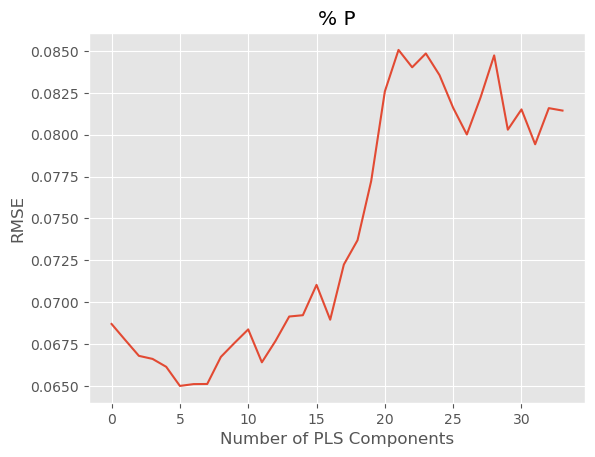

In [158]:
#plot test RMSE vs. number of components
plt.style.use('ggplot')
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title(trait)

In [159]:
### calculate RMSE
pls = PLSRegression(n_components=n_comb)
pls.fit(X_train, y_train)

PLSRegression(n_components=6)

In [160]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

0.0757887430369268

In [161]:
y_pred = pls.predict(X_test)

<AxesSubplot: xlabel='% P', ylabel='Predicted % P values'>

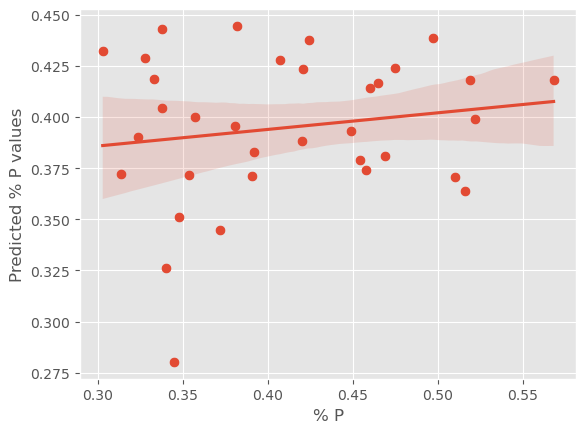

In [162]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)
#plt.text(x=8, y=12.8 , s='r$^2$ = 0.06')

In [163]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r ,r2, p)

0.04186721686907543 0.0017528638483621942 0.8141332044944936


In [164]:
pls = PLSRegression(n_components=n_comb)
score = model_selection.cross_val_score(pls, X, y, cv=cv).mean()

In [135]:
score

0.06196390111008249

# Predicting whole dataset

In [758]:
data = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_2= data_2.loc[:, ['PLOT ID']]
data = pd.merge(data_2, data)
data = data.loc[(data['350'].notnull()), :] #& (data['Group'] == 'Inbred')

In [759]:
data

,PLOT ID,% N,% P,% K,% S,% Ca,% Mg,ppm Zn,ppm Fe,ppm Mn,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035234,0.035088,0.034933,0.034826,0.034614,0.034352,0.034138,0.033865,0.033638,0.033476
1,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037554,0.037249,0.037154,0.037163,0.037074,0.037141,0.037005,0.036618,0.036303,0.035844
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.042723,0.042242,0.042083,0.041943,0.041776,0.041955,0.041835,0.041389,0.041090,0.040662
3,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041980,0.041998,0.041733,0.041467,0.041499,0.041415,0.041049,0.041078,0.041080,0.040855
4,1005,3.521,0.402,1.74,0.308,0.478,0.198,30.0,188.0,56.0,...,0.035746,0.035719,0.035662,0.035373,0.035116,0.034928,0.034894,0.035089,0.035207,0.035318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.059570,0.059487,0.059379,0.059312,0.059066,0.058804,0.058750,0.058499,0.058298,0.058202
2396,4597,3.526,0.377,1.86,0.266,0.515,0.253,53.0,136.0,77.0,...,0.045764,0.045825,0.045893,0.045686,0.045541,0.045311,0.045272,0.045472,0.045199,0.045085
2397,4598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.056652,0.056354,0.056035,0.055800,0.055557,0.055148,0.054880,0.054803,0.054617,0.054308
2398,4599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050402,0.050328,0.050200,0.049665,0.049339,0.049328,0.049174,0.048901,0.048625,0.048320


In [760]:
pos_350 = data.columns.get_loc('350')
pos_2500 = data.columns.get_loc('2500')
train = data.loc[data[trait].notnull() , :]
X_train = train.iloc[:, pos_350:pos_2500]
y_train = train.loc[:, trait]

In [761]:
X_train_index = X_train.index

In [762]:
#Extracting the column names
col_names=X_train.columns
#applying savitzky golay
X_train = savgol_filter(X_train, window_length=5 , polyorder = 2)
X_train = pd.DataFrame(X_train, columns=col_names)
#drop first 100 column
X_train = X_train.drop(X_train.columns[0:100], axis=1)
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)
# Choose from the X based on filtering array
X_train = X_train.iloc[: , column_filter]
X_train.set_index(X_train_index, inplace=True)

In [763]:
y_train = train.loc[: , trait]

In [764]:
test= data.loc[data[trait].isnull(), :]
X_test = test.iloc[:, pos_350:pos_2500]
y_test = test.loc[:, trait]

In [765]:
X_test_index= X_test.index

In [766]:
#Extracting the column names
col_names=X_test.columns
#applying savitzky golay
X_test = savgol_filter(X_test, window_length=5 , polyorder = 2)
X_test = pd.DataFrame(X_test, columns=col_names)
#drop first 100 column
X_test = X_test.drop(X_test.columns[0:100], axis=1)
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)
# Choose from the X based on filtering array
X_test = X_test.iloc[: , column_filter]
X_test.set_index(X_test_index, inplace=True)

In [767]:
y_test=test.loc[:, trait]
y_test = y_test.to_frame(name=trait)

In [768]:
pls = PLSRegression(n_components=n_comb)
score = model_selection.cross_val_score(pls, X_train, y_train, cv=cv).mean()
score

0.0773525596900255

In [769]:
pls = PLSRegression(n_components=n_comb)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

In [770]:
y_test[trait] = y_pred

In [771]:
y_test_index = y_test.index.values

In [772]:
#data_bio = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')

In [773]:
data_bio.loc[y_test_index, trait] = y_test[trait]

In [775]:
data_bio.to_csv('Spectrum_with_biochemical_all_predicted.csv' , index = False)

In [2]:
bio = pd.read_csv('Spectrum_with_biochemical_all_predicted.csv')

In [9]:
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_2= data_2.loc[:, ['PLOT ID', 'Rep', 'Group', 'genotype', 'Trt']]

In [10]:
data = pd.merge(data_2, bio)

In [ ]:
data.iloc[: , 0:17]

In [14]:
data.to_csv('Spectrum_with_biochemical_all_predicted.csv' , index = False)

In [15]:
data

,PLOT ID,Rep,Group,genotype,Trt,% N,% P,% K,% S,% Ca,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1001,1,Inbred,BGEM-0312-S,HN,3.017769,0.375479,2.163853,0.219528,0.382316,...,0.035234,0.035088,0.034933,0.034826,0.034614,0.034352,0.034138,0.033865,0.033638,0.033476
1,1002,1,Inbred,BGEM-0245-S,HN,2.865164,0.369980,2.049509,0.235441,0.440392,...,0.037554,0.037249,0.037154,0.037163,0.037074,0.037141,0.037005,0.036618,0.036303,0.035844
2,1003,1,Inbred,BGEM-0292-S,HN,2.365235,0.363817,2.095909,0.196564,0.466912,...,0.042723,0.042242,0.042083,0.041943,0.041776,0.041955,0.041835,0.041389,0.041090,0.040662
3,1004,1,Inbred,BGEM-0075-S,HN,3.159273,0.365390,1.899305,0.226047,0.402912,...,0.041980,0.041998,0.041733,0.041467,0.041499,0.041415,0.041049,0.041078,0.041080,0.040855
4,1005,1,Inbred,BGEM-0204-N,HN,3.521000,0.402000,1.740000,0.308000,0.478000,...,0.035746,0.035719,0.035662,0.035373,0.035116,0.034928,0.034894,0.035089,0.035207,0.035318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,4596,2,Hybrid,B73 X Mo17,HN,3.395023,0.352327,1.717178,0.247913,0.485109,...,0.059570,0.059487,0.059379,0.059312,0.059066,0.058804,0.058750,0.058499,0.058298,0.058202
2396,4597,2,Hybrid,B73 X Mo17,HN,3.526000,0.377000,1.860000,0.266000,0.515000,...,0.045764,0.045825,0.045893,0.045686,0.045541,0.045311,0.045272,0.045472,0.045199,0.045085
2397,4598,2,Hybrid,B73 X Mo17,HN,3.628085,0.364107,1.762668,0.252947,0.656210,...,0.056652,0.056354,0.056035,0.055800,0.055557,0.055148,0.054880,0.054803,0.054617,0.054308
2398,4599,2,Hybrid,B73 X Mo17,HN,3.198033,0.372690,1.906813,0.237752,0.662582,...,0.050402,0.050328,0.050200,0.049665,0.049339,0.049328,0.049174,0.048901,0.048625,0.048320
